In [1]:
#NLP Assignment 1 Language detection 
#Joshua Pauly

#Make the necessary imports
import os
import sys
import numpy as np
import tarfile
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
from zipfile import ZipFile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant


import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt  

In [2]:
train = pd.read_csv ("tatoeba\sentences.top10langs.train.tsv", sep = '\t', names=["Lang", "Sent"])

  Lang                                               Sent
0  spa  Te di mi corazón para que lo ames, ¡no para us...
1  spa                             Contamos con tu ayuda.
2  spa                Tú eres superficial y materialista.
3  spa                    Los límites son para los demás.
4  spa  Todos ellos esperaron ansiosamente las vacacio...
99863


<AxesSubplot:xlabel='Lang'>

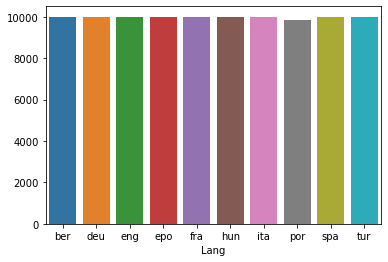

In [3]:
#Data Exploration
#what does the training set look like?
print(train.head())
# Number of rows
print(train.shape[0])
#plot sent by lang uage
Num_sent = train.groupby(['Lang']).size()
 
# plot the result
sns.barplot(x = Num_sent.index, y = Num_sent.values)

From the plot we can see that the languages in the training set are each roughly 10k each. this will make training easier as we have a balanced dataset.

In [4]:
#Preprocessing
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

In [5]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) 
tokenizer.fit_on_texts(train['Sent']) 

train_sequences = tokenizer.texts_to_sequences(train['Sent']) #Converting text to a vector of word indexes 

word_index = tokenizer.word_index 

print('Found %s unique tokens.' % len(word_index))

Found 101396 unique tokens.


In [6]:
train['code'] = train['Lang'].replace({'ber': 0, 'deu': 1, 'eng': 2, 'epo': 3, 'fra': 4, 'hun': 5, 'ita': 6, 'por': 7, 'spa': 8, 'tur': 9})
print(train.head())


  Lang                                               Sent  code
0  spa  Te di mi corazón para que lo ames, ¡no para us...     8
1  spa                             Contamos con tu ayuda.     8
2  spa                Tú eres superficial y materialista.     8
3  spa                    Los límites son para los demás.     8
4  spa  Todos ellos esperaron ansiosamente las vacacio...     8


In [7]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
#test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

trainvalid_labels = to_categorical(np.asarray(train['code']))
#test_labels = to_categorical(np.asarray(test_labels))

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])

x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [8]:
print(y_train.shape)

(79891, 10)


In [9]:
# total number of tags
NUM_CLASSES = y_train.shape[1]
print(NUM_CLASSES)

10


LSTM RNN Model

In [11]:
print("Defining and training an LSTM model, training embedding layer on the fly")

#model
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(10, activation='softmax'))
rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Defining and training an LSTM model, training embedding layer on the fly


In [ ]:
print('Training the RNN')

rnnmodel.fit(x_train, y_train,
          batch_size=128,
          epochs=2,
          validation_data=(x_val, y_val))
score, acc = rnnmodel.evaluate(x_train, y_train,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

In [ ]:
rnnmodel.save_weights("rnnmodel.h5")

In [12]:
rnnmodel.load_weights("rnnmodel.h5")

In [13]:
#Preprocess Test Data

test = pd.read_csv ("tatoeba\sentences.top10langs.dev.tsv", sep = '\t', names=["Lang", "Sent"])
test['code'] = test['Lang'].replace({'ber': 0, 'deu': 1, 'eng': 2, 'epo': 3, 'fra': 4, 'hun': 5, 'ita': 6, 'por': 7, 'spa': 8, 'tur': 9})

test_sequences = tokenizer.texts_to_sequences(test['Sent']) 
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_labels = to_categorical(np.asarray(test['code']))

In [14]:
#Test accuracy on test data

score, acc = rnnmodel.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

10
10
313/313 [==============================] - 30s 92ms/step - loss: 0.0115 - accuracy: 0.9805
Test accuracy with RNN: 0.9804999828338623


In [15]:
#!pip3 install shap

1/1 [==============================] - 0s 313ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

79/79 [==============================] - 7s 93ms/step


79/79 [==============================] - 7s 93ms/step


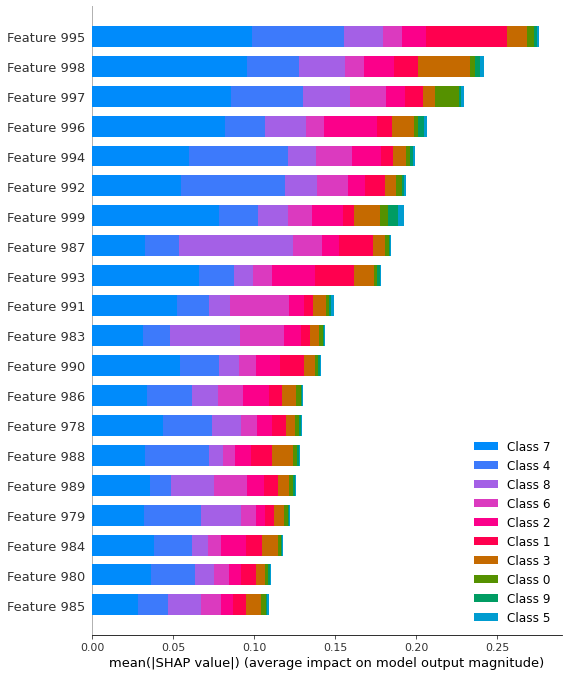

In [16]:
import shap

explainer = shap.KernelExplainer(rnnmodel.predict, shap.kmeans(x_train[:10000],25) )
# send the test data
shap_values = explainer.shap_values(test_data[:100], nsamples=100)



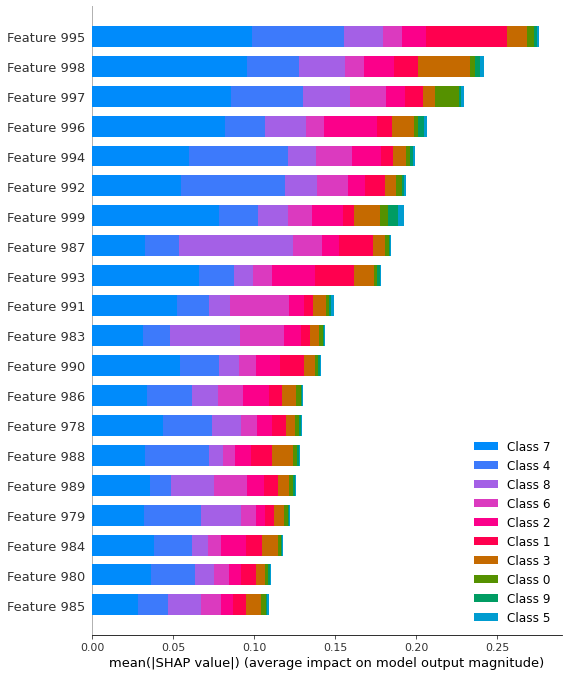

In [21]:
shap.summary_plot(shap_values, test_data[:100])

In [17]:
#!pip install lime

In [20]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=list(range(0, 9)))


def new_predict(texts):
    _seq = tokenizer.texts_to_sequences(texts)
    _text_data = pad_sequences(_seq, maxlen=MAX_SEQUENCE_LENGTH)
    return rnnmodel.predict(_text_data)


exp = explainer.explain_instance(
    'forget reservations thank great company i have cancelled flighted flight once again thank you',
    new_predict,
    num_features=7,
    labels=[0,1,2,3,4,5,6,7,8,9])

print("English is class number 2")
print('Explanation for class 0')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 1')
print('\n'.join(map(str, exp.as_list(label=1))))
print()
print('Explanation for class 2')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 3')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 4')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 5')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 6')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 7')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 8')
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class 9')
print('\n'.join(map(str, exp.as_list(label=0))))

157/157 [==============================] - 16s 101ms/step
English is class number 2
Explanation for class 0
('again', -0.003536393504634475)
('once', -0.0035285228415352027)
('thank', -0.003449498804404102)
('you', -0.0032084473792025146)
('have', -0.003089608016792072)
('forget', -0.0027810676804229948)
('great', -0.002393633049163042)

Explanation for class 1
('you', -6.473239262305321e-05)
('i', -6.249195024119477e-05)
('have', -6.195570615097627e-05)
('again', -5.9449295497665257e-05)
('once', -5.090628179643131e-05)
('forget', -3.2555079645064424e-05)
('thank', -2.5196992923054602e-05)

Explanation for class 2
('again', -0.003536393504634475)
('once', -0.0035285228415352027)
('thank', -0.003449498804404102)
('you', -0.0032084473792025146)
('have', -0.003089608016792072)
('forget', -0.0027810676804229948)
('great', -0.002393633049163042)

Explanation for class 3
('again', -0.003536393504634475)
('once', -0.0035285228415352027)
('thank', -0.003449498804404102)
('you', -0.00320844737

In [ ]:
print(test_labels)